<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


# **Imports**

In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


We mount google drive into the Python environment.

In [26]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
!pwd

/content


In [5]:
! ls

gdrive		      LectureModel_080.pth  LectureModel_160.pth   sample_data
LectureModel_020.pth  LectureModel_100.pth  LectureModel_180.pth
LectureModel_040.pth  LectureModel_120.pth  LectureModel8_020.pth
LectureModel_060.pth  LectureModel_140.pth  LectureModel8_040.pth


# **Data preparation**

Let's create a class to open the dataset. For now I am not going to apply any relevant data augmentation. I'll just inspect the data

In [6]:
class HandXRayDataset(Dataset):   #Created this class with the help of ChatGPT
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.file_names = os.listdir(directory)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.file_names[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
]) #simple just to inspect at first


dataset = HandXRayDataset('gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/real_hands', transform=transform)

In [7]:
dataset

We check that we have the 8000 samples

In [8]:
len(dataset)

8000

Let's look at some of the images.

Image 0: Shape - torch.Size([1, 32, 32])


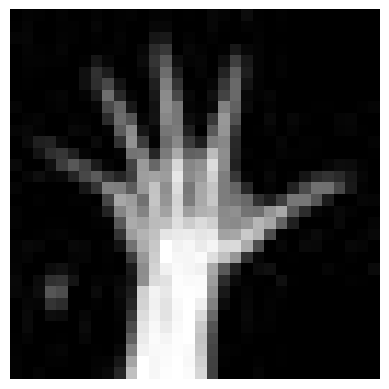

Image 1: Shape - torch.Size([1, 32, 32])


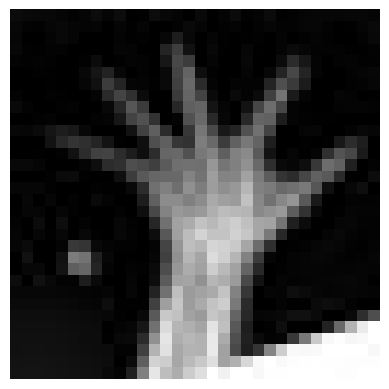

Image 2: Shape - torch.Size([1, 32, 32])


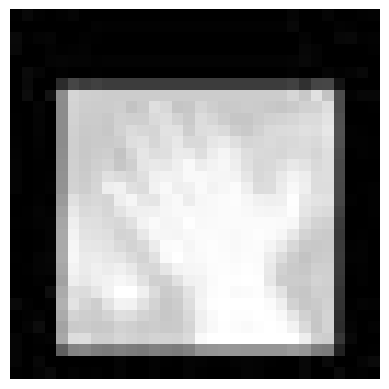

Image 3: Shape - torch.Size([1, 32, 32])


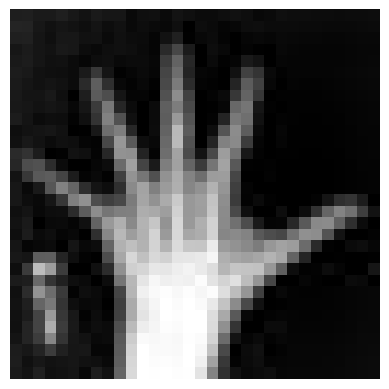

Image 4: Shape - torch.Size([1, 32, 32])


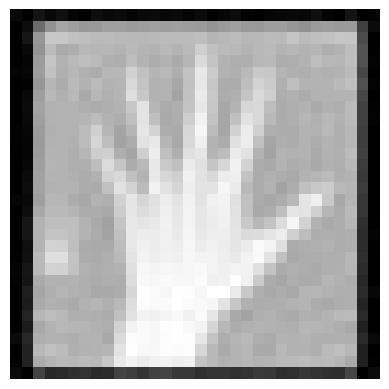

In [9]:
import matplotlib.pyplot as plt

def show_image(image_tensor):

    image = image_tensor.numpy().transpose(1, 2, 0) #match matplotlib notation
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

for i in range(5):
    image_tensor = dataset[i]
    print(f"Image {i}: Shape - {image_tensor.size()}")  #shape of the images
    show_image(image_tensor)

We can see that the images have 1 channel and a shape of 32x32.
Also, some images contain a weird white square. We need to take this into account when doing data preparation

Without any data preparation, I am just going to build a GAN, to see how it works and stablish a "baseline".

# Baseline with no data preparation (GAN model)

We are just going to use the GAN architecture we saw at class, only to check if everything works properly.

First, I will create the data loader. I am going to use the whole dataset for training, then, I won't have to split into train and validation (it makes no sense in GANs, as the images generated are new)

In [10]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [11]:
dataloader

Let's define the `Generator` and the `Discriminator`.

In [12]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=50, g_output_dim=32*32):
        super().__init__()
        self.fc1 = nn.Linear(g_input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim=32*32):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))


# build model
G = Generator().to(device)
D = Discriminator().to(device)

We check that the output of the generator is the input of the discriminator

In [13]:
G

Generator(
  (fc1): Linear(in_features=50, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
)

In [14]:
D

Discriminator(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

We define some hyperparameters. Let's just use the same as we did in class.

In [15]:
criterion = nn.BCELoss()
z_dim = 50
bs = 100  ## batch_size


# optimiser
lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

Define the training functions to loop through

In [16]:

def D_train(x):
    #-------------- Function of the discriminator training -------------------#
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    x_real, y_real = x.view(-1, 32*32), torch.ones(bs, 1)  # we are assigning the label 'real data' to the samples (don't care anymore about what number they are)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [17]:

def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    G_loss = criterion(D_output, y)

    # model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

In [18]:
set_seed(0)
n_epoch = 200 # about 40 minutes
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, x in enumerate(dataloader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./LectureModel_{:03d}.pth".format(epoch))


KeyboardInterrupt: ignored

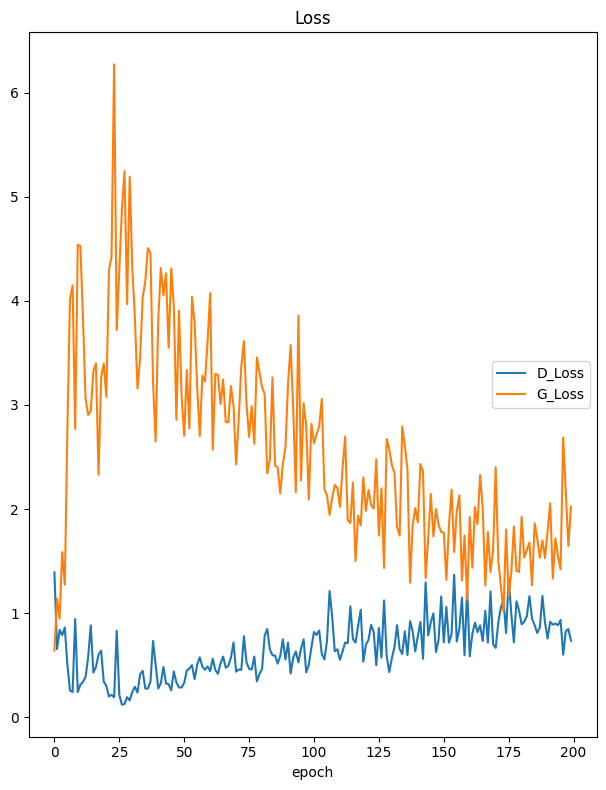

In [19]:
img_path = 'gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/ModelsImages/LectureModelNoDataCleaning.png'
img = Image.open(img_path)
img

We can see that the model needs more than 200 epochs to converge (if it converges ... ).

Let's generate images:

KeyboardInterrupt: ignored

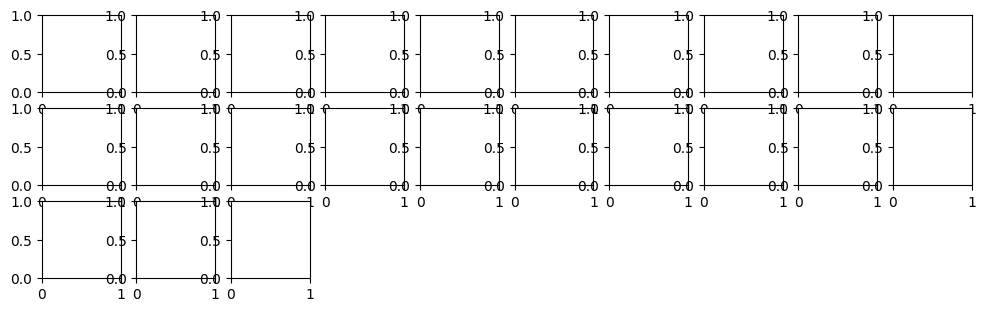

In [30]:
set_seed(0)

epoch = 20  # Load the model after 20 epochs
G.load_state_dict(torch.load("./LectureModel_{:03d}.pth".format(epoch)))
G.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


In [ ]:
set_seed(0)

epoch = 60  # Load the model after 20 epochs
G.load_state_dict(torch.load("./LectureModel_{:03d}.pth".format(epoch)))
G.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


In [ ]:
set_seed(0)

epoch = 140  # Load the model after 20 epochs
G.load_state_dict(torch.load("./LectureModel_{:03d}.pth".format(epoch)))
G.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()

In [ ]:
set_seed(0)

epoch = 200  # Load the model after 20 epochs
G.load_state_dict(torch.load("./LectureModel_{:03d}.pth".format(epoch)))
G.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()

We can appreciate that the white squares we saw in the data exploration stage, are spoiling our new created images.

I am not sure if those images carry relevant information (like labels or markers for certain conditions in the hands), but it is clear that it's not helping to generate proper hands. It makes our model worse.

So, I will try to see how many images contain this white square, and if they aren't that many, then I will delete them from the dataset.

Even if those images with white squares carry relevant information (like labels or markers for certain conditions in the hands), it will make the model worse.
To solve this problem, I will look at the number of black pixels in the image. If it is too little, then I will delete that image, if not, I will keep it

# **Real Data Preprocessing**

I am going to analyse the number of black pixels the images contain.

In [10]:
def contains_few_black_pixels(image, threshold):
    """
    Checks if the image contains few black pixels below a certain threshold.
    ------------------------------------------------------------------------
    parameters
    -----------
      - image: numpy array of the image.
      - threshold: the ratio of black pixels to the total number of pixels.

    return
    -------
    boolean indicating if the image contains few black pixels

    """


    black_pixels = np.sum(image < (255 * threshold))


    black_pixel_ratio = black_pixels / image.size


    return black_pixel_ratio < threshold

In [11]:
class HandXRayDataset(Dataset):
    def __init__(self, directory, transform=None, filter_images=True, black_pixel_threshold=0.5):
        self.directory = directory
        self.transform = transform
        self.file_names = []

        for file_name in os.listdir(directory):
            img_path = os.path.join(directory, file_name)
            image = Image.open(img_path).convert('L')
            image_array = np.array(image)

            # Filter images based on the number of black pixels
            if not filter_images or not contains_few_black_pixels(image_array, black_pixel_threshold):
                self.file_names.append(file_name)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.file_names[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])


dataset = HandXRayDataset(
    'gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/real_hands',
    transform=transform,
    filter_images=True,
    black_pixel_threshold=0.5
)

After trying different threshold values, I found that a threshold of 0.5 deletes effectively the white squared images

In [13]:
len(dataset)

7613

So we've gone from 8000 samples to 7613. We just reduced our dataset a 5%. I consider it to be a really small part of the dataset, so I will delete those.

Image 0: Shape - torch.Size([1, 32, 32])


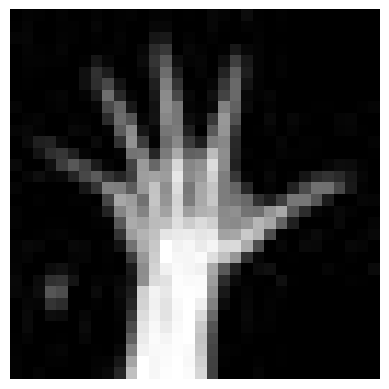

Image 1: Shape - torch.Size([1, 32, 32])


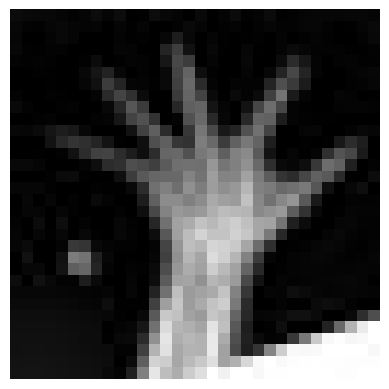

Image 2: Shape - torch.Size([1, 32, 32])


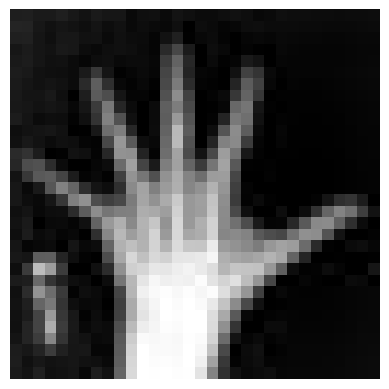

Image 3: Shape - torch.Size([1, 32, 32])


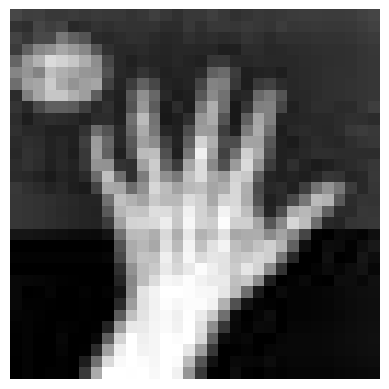

Image 4: Shape - torch.Size([1, 32, 32])


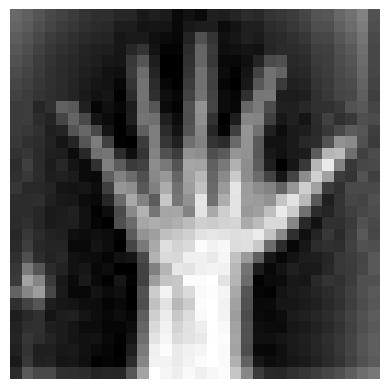

In [14]:
import matplotlib.pyplot as plt

def show_image(image_tensor):

    image = image_tensor.numpy().transpose(1, 2, 0) #match matplotlib notation
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

for i in range(5):
    image_tensor = dataset[i]
    print(f"Image {i}: Shape - {image_tensor.size()}")  #shape of the images
    show_image(image_tensor)

Now we don't see those white squared images here :)

In [15]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

Let's run again the first GAN we had.

In [16]:
set_seed(0)
n_epoch = 400 # about 80 minutes
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, x in enumerate(dataloader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./LectureModel2_{:03d}.pth".format(epoch))


NameError: ignored

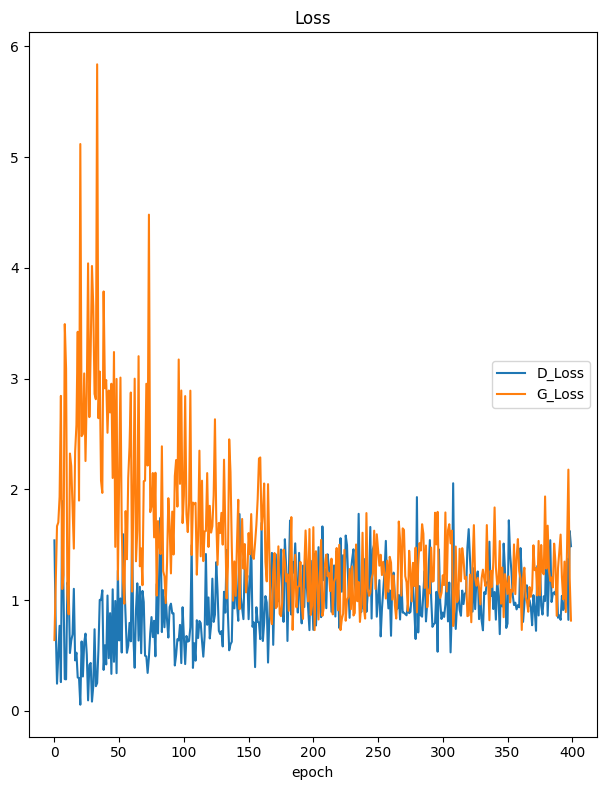

In [21]:
img_path = 'gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/ModelsImages/LectureModel.png'
img = Image.open(img_path)
img

Let's see the images. Maybe now they look better after this data preprocessing

In [ ]:
set_seed(0)

epoch = 120  # Load the model after 20 epochs
G.load_state_dict(torch.load("./LectureModel2_{:03d}.pth".format(epoch)))
G.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


In [ ]:
set_seed(0)

epoch = 160  # Load the model after 20 epochs
G.load_state_dict(torch.load("./LectureModel2_{:03d}.pth".format(epoch)))
G.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


In [ ]:
set_seed(0)

epoch = 200  # Load the model after 20 epochs
G.load_state_dict(torch.load("./LectureModel2_{:03d}.pth".format(epoch)))
G.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


In [ ]:
set_seed(0)

epoch = 300  # Load the model after 20 epochs
G.load_state_dict(torch.load("./LectureModel2_{:03d}.pth".format(epoch)))
G.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


In [ ]:
set_seed(0)

epoch = 400  # Load the model after 20 epochs
G.load_state_dict(torch.load("./LectureModel2_{:03d}.pth".format(epoch)))
G.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


I believe they are better now

# **Trying other models and Hyperparameter tunning**

Let's modify the architecture of the previous model. I am going to make a deeper network, in this way, the model may capture more complex and high-level features, potentially improving the quality and realism of generated images.

However, we need to take into account that they might be harder to train due to vanishing or exploding gradients.

In [ ]:
class Generator2(nn.Module):
    def __init__(self, g_input_dim=50, g_output_dim=1024):
        super().__init__()
        self.fc1 = nn.Linear(g_input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 512)  # Additional layer
        self.fc5 = nn.Linear(512, 512)  # Additional layer
        self.fc6 = nn.Linear(512, 1024) # Adjusted to 1024 for final output

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.leaky_relu(self.fc4(x), 0.2)
        x = F.leaky_relu(self.fc5(x), 0.2)
        return torch.tanh(self.fc6(x))



class Discriminator2(nn.Module):
    def __init__(self, d_input_dim=1024):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 512)  # Additional layer
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 1)    # Final layer outputting a scalar

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc4(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc5(x), 0.2)
        return torch.sigmoid(self.fc6(x))


# build model
G2 = Generator2().to(device)
D2 = Discriminator2().to(device)

In [ ]:
criterion = nn.BCELoss()
z_dim = 50
bs = 100  ## batch_size


# optimiser
lr = 0.0001
G2_optimizer = torch.optim.Adam(G2.parameters(), lr = lr)
D2_optimizer = torch.optim.Adam(D2.parameters(), lr = lr)

In [ ]:
def D2_train(x):

    D2.train()
    D2_optimizer.zero_grad()

    # Adjusting to dynamic batch size
    current_batch_size = x.size(0)

    # Train discriminator on real data
    x_real, y_real = x.view(-1, 32*32), torch.ones(current_batch_size, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D2_output = D(x_real)
    D2_real_loss = criterion(D2_output, y_real)

    # Train discriminator on fake data
    z = torch.randn(current_batch_size, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(current_batch_size, 1).to(device)

    D2_output = D2(x_fake)
    D2_fake_loss = criterion(D2_output, y_fake)

    # Combine the losses
    D2_loss = D2_real_loss + D2_fake_loss

    # Model update
    D2_loss.backward()
    D2_optimizer.step()

    return D2_loss.data.item()

In [ ]:

def G2_train(x):
    #-------------- Function of the generator training -------------------#

    G2.train()
    G2_optimizer.zero_grad()

    # Adjusting to dynamic batch size
    current_batch_size = x.size(0)

    z = torch.randn(current_batch_size, z_dim).to(device)
    G2_output = G2(z)

    # Obtain scores from D for the generated data
    D2_output = D2(G2_output)

    # Train generator to "fool" discriminator
    y = torch.ones(current_batch_size, 1).to(device)
    G2_loss = criterion(D2_output, y)

    # Model update
    G2_loss.backward()
    G2_optimizer.step()

    return G2_loss.data.item()

In [ ]:
set_seed(0)
n_epoch = 200 # about 40 minutes
groups = {'Loss': ['D2_Loss', 'G2_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D2_losses, G2_losses = [], []
  logs = {}
  for batch_idx, x in enumerate(dataloader):
    logs['D2_Loss'] = D2_train(x)
    logs['G2_Loss'] = G2_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G2.state_dict(), "./LinearModel2_{:03d}.pth".format(epoch))

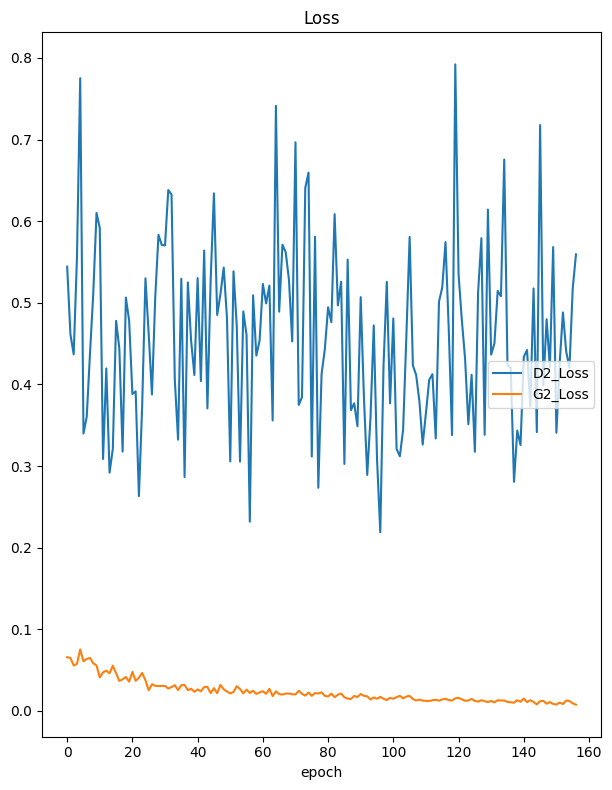

In [23]:
img_path = 'gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/ModelsImages/ModeloLinearOtraArq.png'
img = Image.open(img_path)
img

In [ ]:
set_seed(0)

epoch = 20  # Load the model after 20 epochs
G2.load_state_dict(torch.load("./LinearModel2_{:03d}.pth".format(epoch)))
G2.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G2(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


In [ ]:
set_seed(0)

epoch = 160  # Load the model after 20 epochs
G2.load_state_dict(torch.load("./LinearModel2_{:03d}.pth".format(epoch)))
G2.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim).to(device)  # Generate a batch of 100 latent vectors
        generated = G2(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


This model is not performing well.

Let's try to implement CNNs

## **DCGAN**

I am going to start with a simple architecture

In [ ]:
class Generator7(nn.Module):
    def __init__(self, latent_dim):
        super(Generator7, self).__init__()
        self.model = nn.Sequential(

            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Upsample to 8x8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample to 16x16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # Upsample to 32x32
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)



class Discriminator7(nn.Module):
    def __init__(self):
        super(Discriminator7, self).__init__()
        self.model = nn.Sequential(
            # Input is a 1x32x32 image
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 16x16
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 8x8
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

G7 = Generator7(50).to(device)
D7 = Discriminator7().to(device)

In the paper **Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks**, written by Alec Radford, Luke Metz, Soumith Chintala (DOI:
https://doi.org/10.48550/arXiv.1511.06434),  the authors recommend using an Adam optimizer with **beta1 set to 0.5 and beta2 to 0.999**. This configuration was found to be effective for the training of DCGANs, with beta1=0.5 helping to stabilize training in the adversarial setting by allowing quicker adaptation to changes in gradients.

So, let's use it!


In [ ]:
criterion = nn.BCELoss()
z_dim = 50
bs = 100  ## batch_size

beta1 = 0.5
beta2 = 0.999

# optimiser
lr = 0.0001
G7_optimizer = torch.optim.Adam(G7.parameters(), lr = lr, betas=(beta1, beta2))
D7_optimizer = torch.optim.Adam(D7.parameters(), lr = lr, betas=(beta1, beta2))

In [ ]:
def D7_train(x):
    current_batch_size = x.size(0)  # Get the actual size of the batch

    D7.zero_grad()

    # Train with real images
    real_data = x.to(device)
    real_labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size
    output = D7(real_data).view(-1, 1)
    D7_real_loss = criterion(output, real_labels)

    # Train with fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G7(noise)
    fake_labels = torch.zeros(current_batch_size, 1).to(device)  # Adjust label size
    output = D7(fake_data.detach()).view(-1, 1)
    D7_fake_loss = criterion(output, fake_labels)

    # Combine losses and perform backpropagation
    D7_loss = D7_real_loss + D7_fake_loss
    D7_loss.backward()
    D7_optimizer.step()

    return D7_loss.item()

In [ ]:
def G7_train(current_batch_size):  # Add current_batch_size as an argument
    G7.zero_grad()

    # Generate fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G7(noise)
    labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size

    # Calculate the generator's loss
    output = D7(fake_data).view(-1, 1)
    G7_loss = criterion(output, labels)

    # Backpropagation
    G7_loss.backward()
    G7_optimizer.step()

    return G7_loss.item()

In [ ]:
set_seed(0)
n_epoch = 400
# Assuming livelossplot is installed and imported if you plan to use it
# from livelossplot import PlotLosses

groups = {'Loss': ['D7_Loss', 'G7_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D7_losses, G7_losses = [], []
    logs = {}

    for batch_idx, x in enumerate(dataloader):
        # Handling the case for the last batch which might be smaller
        current_batch_size = x.size(0)

        # Update the discriminator
        D7_loss = D7_train(x)
        D7_losses.append(D7_loss)

        # Update the generator
        G7_loss = G7_train(current_batch_size)  # Pass the current batch size to G_train
        G7_losses.append(G7_loss)

        # Update logs for livelossplot, if used
        logs['D7_Loss'] = D7_loss
        logs['G7_Loss'] = G7_loss

    liveloss.update(logs)
    liveloss.draw()

    # Save model checkpoints
    if epoch % 20 == 0:
        torch.save(G7.state_dict(), f"./LectureModel7_{epoch:03d}.pth")

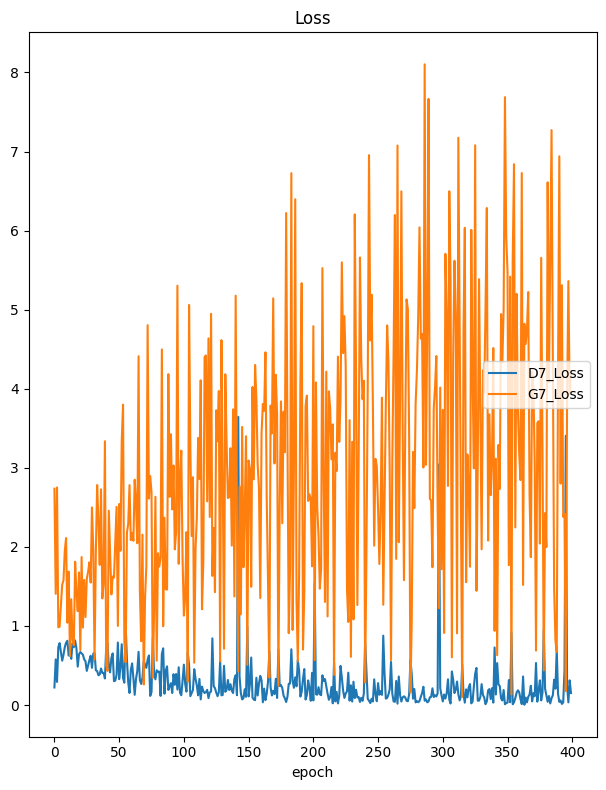

In [24]:
img_path = 'gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/ModelsImages/DCGAN1.png'
img = Image.open(img_path)
img

In [ ]:
set_seed(0)

epoch = 380  # Load the model after 20 epochs
G7.load_state_dict(torch.load("./LectureModel7_{:03d}.pth".format(epoch)))
G7.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim, 1, 1).to(device)  # Generate a batch of 100 latent vectors
        generated = G7(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


Even though the D and G loss don't converge, we obtain better visual images. This may be because linear layers lack the spatial hierarchy of features that convolutional layers offer. Convolutional layers in DCGANs are adept at capturing and processing the spatial and hierarchical patterns in images, which is crucial for generating realistic and detailed images. Linear models, on the other hand, do not process image data in a way that preserves spatial relationships, leading to less accurate and visually appealing results.

For now, we will keep this model as the best, even though the curves do not converge.

We can try to add biases.

In [ ]:
class Generator8(nn.Module):
    def __init__(self, latent_dim):
        super(Generator8, self).__init__()
        self.model = nn.Sequential(
            # First layer, projecting and reshaping the latent vector
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Upsample to 8x8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample to 16x16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # Upsample to 32x32
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=True),
            nn.Tanh()  # Tanh for normalizing the output to [-1, 1]
        )

    def forward(self, z):
        return self.model(z)



class Discriminator8(nn.Module):
    def __init__(self):
        super(Discriminator8, self).__init__()
        self.model = nn.Sequential(
            # Input is a 1x32x32 image
            nn.Conv2d(1, 32, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 16x16
            nn.Conv2d(32, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 8x8
            nn.Conv2d(64, 128, 4, 2, 1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer
            nn.Conv2d(128, 1, 4, 1, 0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

G8 = Generator8(50).to(device)
D8 = Discriminator8().to(device)

In [ ]:
criterion = nn.BCELoss()
z_dim = 50
bs = 100  ## batch_size

beta1 = 0.5
beta2 = 0.999

# optimiser
lr = 0.0001
G8_optimizer = torch.optim.Adam(G8.parameters(), lr = lr, betas=(beta1, beta2))
D8_optimizer = torch.optim.Adam(D8.parameters(), lr = lr, betas=(beta1, beta2))

In [ ]:
def D8_train(x):
    current_batch_size = x.size(0)  # Get the actual size of the batch

    D8.zero_grad()

    # Train with real images
    real_data = x.to(device)
    real_labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size
    output = D8(real_data).view(-1, 1)
    D8_real_loss = criterion(output, real_labels)

    # Train with fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G8(noise)
    fake_labels = torch.zeros(current_batch_size, 1).to(device)  # Adjust label size
    output = D8(fake_data.detach()).view(-1, 1)
    D8_fake_loss = criterion(output, fake_labels)

    # Combine losses and perform backpropagation
    D8_loss = D8_real_loss + D8_fake_loss
    D8_loss.backward()
    D8_optimizer.step()

    return D8_loss.item()

In [ ]:
def G8_train(current_batch_size):  # Add current_batch_size as an argument
    G8.zero_grad()

    # Generate fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G8(noise)
    labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size

    # Calculate the generator's loss
    output = D8(fake_data).view(-1, 1)
    G8_loss = criterion(output, labels)

    # Backpropagation
    G8_loss.backward()
    G8_optimizer.step()

    return G8_loss.item()

In [ ]:
set_seed(0)
n_epoch = 400
# Assuming livelossplot is installed and imported if you plan to use it
# from livelossplot import PlotLosses

groups = {'Loss': ['D8_Loss', 'G8_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D8_losses, G8_losses = [], []
    logs = {}

    for batch_idx, x in enumerate(dataloader):
        # Handling the case for the last batch which might be smaller
        current_batch_size = x.size(0)

        # Update the discriminator
        D8_loss = D8_train(x)
        D8_losses.append(D8_loss)

        # Update the generator
        G8_loss = G8_train(current_batch_size)  # Pass the current batch size to G_train
        G8_losses.append(G8_loss)

        # Update logs for livelossplot, if used
        logs['D8_Loss'] = D8_loss
        logs['G8_Loss'] = G8_loss

    liveloss.update(logs)
    liveloss.draw()

    # Save model checkpoints
    if epoch % 20 == 0:
        torch.save(G8.state_dict(), f"./LectureModel8_{epoch:03d}.pth")

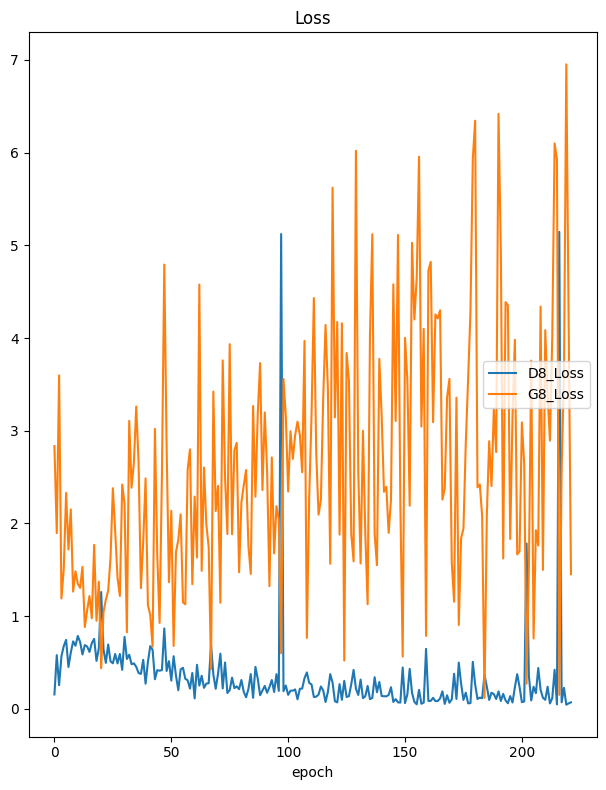

In [25]:
img_path = 'gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/ModelsImages/DCGANBiasT.png'
img = Image.open(img_path)
img

We obtain same thing as before. So the biases are not that relevant for the GAN behaviour (in this case).

We are observing that the main problem is that the curves do not converge. The discriminator seems to be too good. Let's try to fix this !

In the paper: **Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification** (DOI: https://doi.org/10.48550/arXiv.1502.01852)

The authors emphasise the significant impact of weight initialization on the training of deep neural networks. Proper initialization is crucial for achieving convergence, especially in networks with ReLU activations, like mine. It considers the non-linear nature of ReLU and initializes weights in a way that helps preserve the variance of activations throughout the layers, thus facilitating effective gradient flow. The authors demonstrate through experiments that **He initialization** enables the training of very deep networks from scratch, which otherwise might struggle to converge with other initialization methods like **Xavier (Glorot) initialization**. So, we can try to use it.





In [ ]:
def weights_init_he(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [ ]:
class Generator9(nn.Module):
    def __init__(self, latent_dim):
        super(Generator9, self).__init__()
        self.model = nn.Sequential(
            # First layer, projecting and reshaping the latent vector
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Upsample to 8x8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample to 16x16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # Upsample to 32x32
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=True),
            nn.Tanh()  # Tanh for normalizing the output to [-1, 1]
        )

    def forward(self, z):
        return self.model(z)



class Discriminator9(nn.Module):
    def __init__(self):
        super(Discriminator9, self).__init__()
        self.model = nn.Sequential(
            # Input is a 1x32x32 image
            nn.Conv2d(1, 32, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 16x16
            nn.Conv2d(32, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 8x8
            nn.Conv2d(64, 128, 4, 2, 1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer
            nn.Conv2d(128, 1, 4, 1, 0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

G9 = Generator9(50).to(device)
D9 = Discriminator9().to(device)


G9 = Generator9(50).to(device)
G9.apply(weights_init_he)
D9 = Discriminator9().to(device)
D9.apply(weights_init_he)

In [ ]:
criterion = nn.BCELoss()
z_dim = 50
bs = 100  ## batch_size

beta1 = 0.5
beta2 = 0.999

# optimiser
lr = 0.0001
G9_optimizer = torch.optim.Adam(G9.parameters(), lr = lr, betas=(beta1, beta2))
D9_optimizer = torch.optim.Adam(D9.parameters(), lr = lr, betas=(beta1, beta2))

In [ ]:
def D9_train(x):
    current_batch_size = x.size(0)  # Get the actual size of the batch

    D9.zero_grad()

    # Train with real images
    real_data = x.to(device)
    real_labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size
    output = D9(real_data).view(-1, 1)
    D9_real_loss = criterion(output, real_labels)

    # Train with fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G9(noise)
    fake_labels = torch.zeros(current_batch_size, 1).to(device)  # Adjust label size
    output = D9(fake_data.detach()).view(-1, 1)
    D9_fake_loss = criterion(output, fake_labels)

    # Combine losses and perform backpropagation
    D9_loss = D9_real_loss + D9_fake_loss
    D9_loss.backward()
    D9_optimizer.step()

    return D9_loss.item()

In [ ]:
def G9_train(current_batch_size):  # Add current_batch_size as an argument
    G9.zero_grad()

    # Generate fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G9(noise)
    labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size

    # Calculate the generator's loss
    output = D9(fake_data).view(-1, 1)
    G9_loss = criterion(output, labels)

    # Backpropagation
    G9_loss.backward()
    G9_optimizer.step()

    return G9_loss.item()

In [ ]:
set_seed(0)
n_epoch = 400
# Assuming livelossplot is installed and imported if you plan to use it
# from livelossplot import PlotLosses

groups = {'Loss': ['D9_Loss', 'G9_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D9_losses, G9_losses = [], []
    logs = {}

    for batch_idx, x in enumerate(dataloader):
        # Handling the case for the last batch which might be smaller
        current_batch_size = x.size(0)

        # Update the discriminator
        D9_loss = D9_train(x)
        D9_losses.append(D9_loss)

        # Update the generator
        G9_loss = G9_train(current_batch_size)  # Pass the current batch size to G_train
        G9_losses.append(G9_loss)

        # Update logs for livelossplot, if used
        logs['D9_Loss'] = D9_loss
        logs['G9_Loss'] = G9_loss

    liveloss.update(logs)
    liveloss.draw()

    # Save model checkpoints
    if epoch % 20 == 0:
        torch.save(G9.state_dict(), f"./LectureModel9_{epoch:03d}.pth")

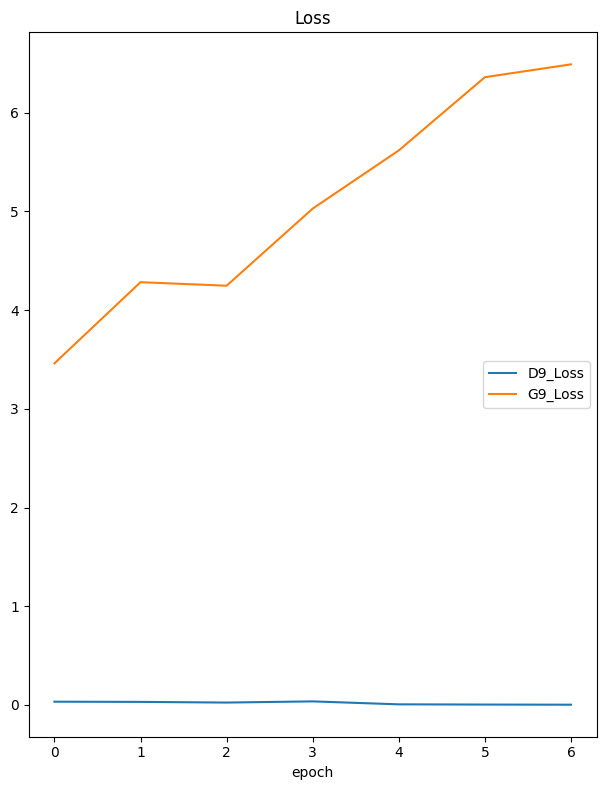

In [26]:
img_path = 'gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/ModelsImages/DCGANHe.png'
img = Image.open(img_path)
img

In our case this is not working. This may be due to the fact that our network is not very deep. And they explicitally said that it worked on deep networks.

First I'll try other type of initialisers with this architecture, and then, I'll try to make the network deeper so that we can use the He initialisation.

Let's try a Standard Normalisation initialisation

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
class Generator8(nn.Module):
    def __init__(self, latent_dim):
        super(Generator8, self).__init__()
        self.model = nn.Sequential(
            # First layer, projecting and reshaping the latent vector
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Upsample to 8x8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample to 16x16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # Upsample to 32x32
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=True),
            nn.Tanh()  # Tanh for normalizing the output to [-1, 1]
        )

    def forward(self, z):
        return self.model(z)



class Discriminator8(nn.Module):
    def __init__(self):
        super(Discriminator8, self).__init__()
        self.model = nn.Sequential(
            # Input is a 1x32x32 image
            nn.Conv2d(1, 32, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 16x16
            nn.Conv2d(32, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 8x8
            nn.Conv2d(64, 128, 4, 2, 1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer
            nn.Conv2d(128, 1, 4, 1, 0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

G8 = Generator8(50).to(device)
G8.apply(weights_init)
D8 = Discriminator8().to(device)
D8.apply(weights_init)

Discriminator8(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1))
    (9): Sigmoid()
  )
)

In [19]:
criterion = nn.BCELoss()
z_dim = 50
bs = 100  ## batch_size

beta1 = 0.5
beta2 = 0.999

# optimiser
lr = 0.0001
G8_optimizer = torch.optim.Adam(G8.parameters(), lr = lr, betas=(beta1, beta2))
D8_optimizer = torch.optim.Adam(D8.parameters(), lr = lr, betas=(beta1, beta2))

In [20]:
def D8_train(x):
    current_batch_size = x.size(0)  # Get the actual size of the batch

    D8.zero_grad()

    # Train with real images
    real_data = x.to(device)
    real_labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size
    output = D8(real_data).view(-1, 1)
    D8_real_loss = criterion(output, real_labels)

    # Train with fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G8(noise)
    fake_labels = torch.zeros(current_batch_size, 1).to(device)  # Adjust label size
    output = D8(fake_data.detach()).view(-1, 1)
    D8_fake_loss = criterion(output, fake_labels)

    # Combine losses and perform backpropagation
    D8_loss = D8_real_loss + D8_fake_loss
    D8_loss.backward()
    D8_optimizer.step()

    return D8_loss.item()

In [21]:
def G8_train(current_batch_size):  # Add current_batch_size as an argument
    G8.zero_grad()

    # Generate fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G8(noise)
    labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size

    # Calculate the generator's loss
    output = D8(fake_data).view(-1, 1)
    G8_loss = criterion(output, labels)

    # Backpropagation
    G8_loss.backward()
    G8_optimizer.step()

    return G8_loss.item()

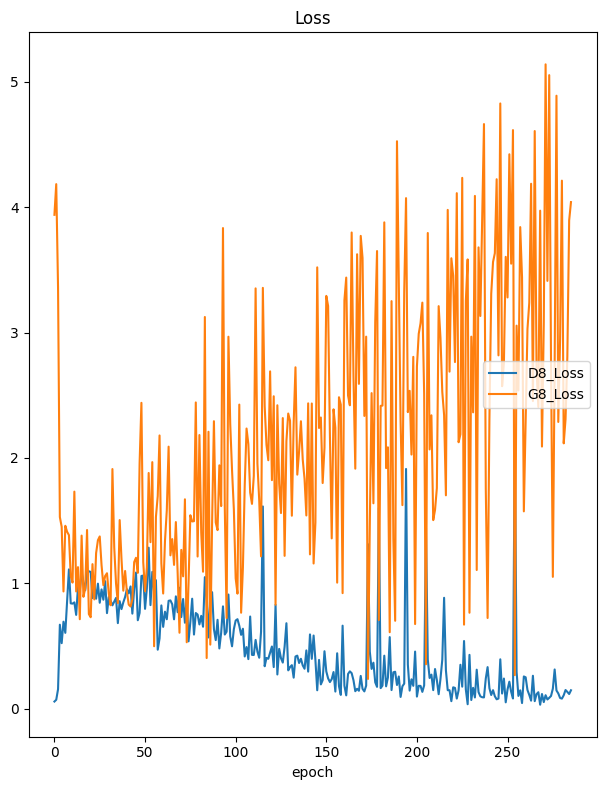

Loss
	D8_Loss          	 (min:    0.030, max:    2.220, cur:    0.146)
	G8_Loss          	 (min:    0.236, max:    5.140, cur:    4.041)


KeyboardInterrupt: ignored

In [22]:
set_seed(0)
n_epoch = 400
# Assuming livelossplot is installed and imported if you plan to use it
# from livelossplot import PlotLosses

groups = {'Loss': ['D8_Loss', 'G8_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D8_losses, G8_losses = [], []
    logs = {}

    for batch_idx, x in enumerate(dataloader):
        # Handling the case for the last batch which might be smaller
        current_batch_size = x.size(0)

        # Update the discriminator
        D8_loss = D8_train(x)
        D8_losses.append(D8_loss)

        # Update the generator
        G8_loss = G8_train(current_batch_size)  # Pass the current batch size to G_train
        G8_losses.append(G8_loss)

        # Update logs for livelossplot, if used
        logs['D8_Loss'] = D8_loss
        logs['G8_Loss'] = G8_loss

    liveloss.update(logs)
    liveloss.draw()

    # Save model checkpoints
    if epoch % 20 == 0:
        torch.save(G8.state_dict(), f"./LectureModel8_{epoch:03d}.pth")

We can see that with this initialisation, we are forcing the curves to come together in the beginning. However, they separate as the number of epochs increase ...

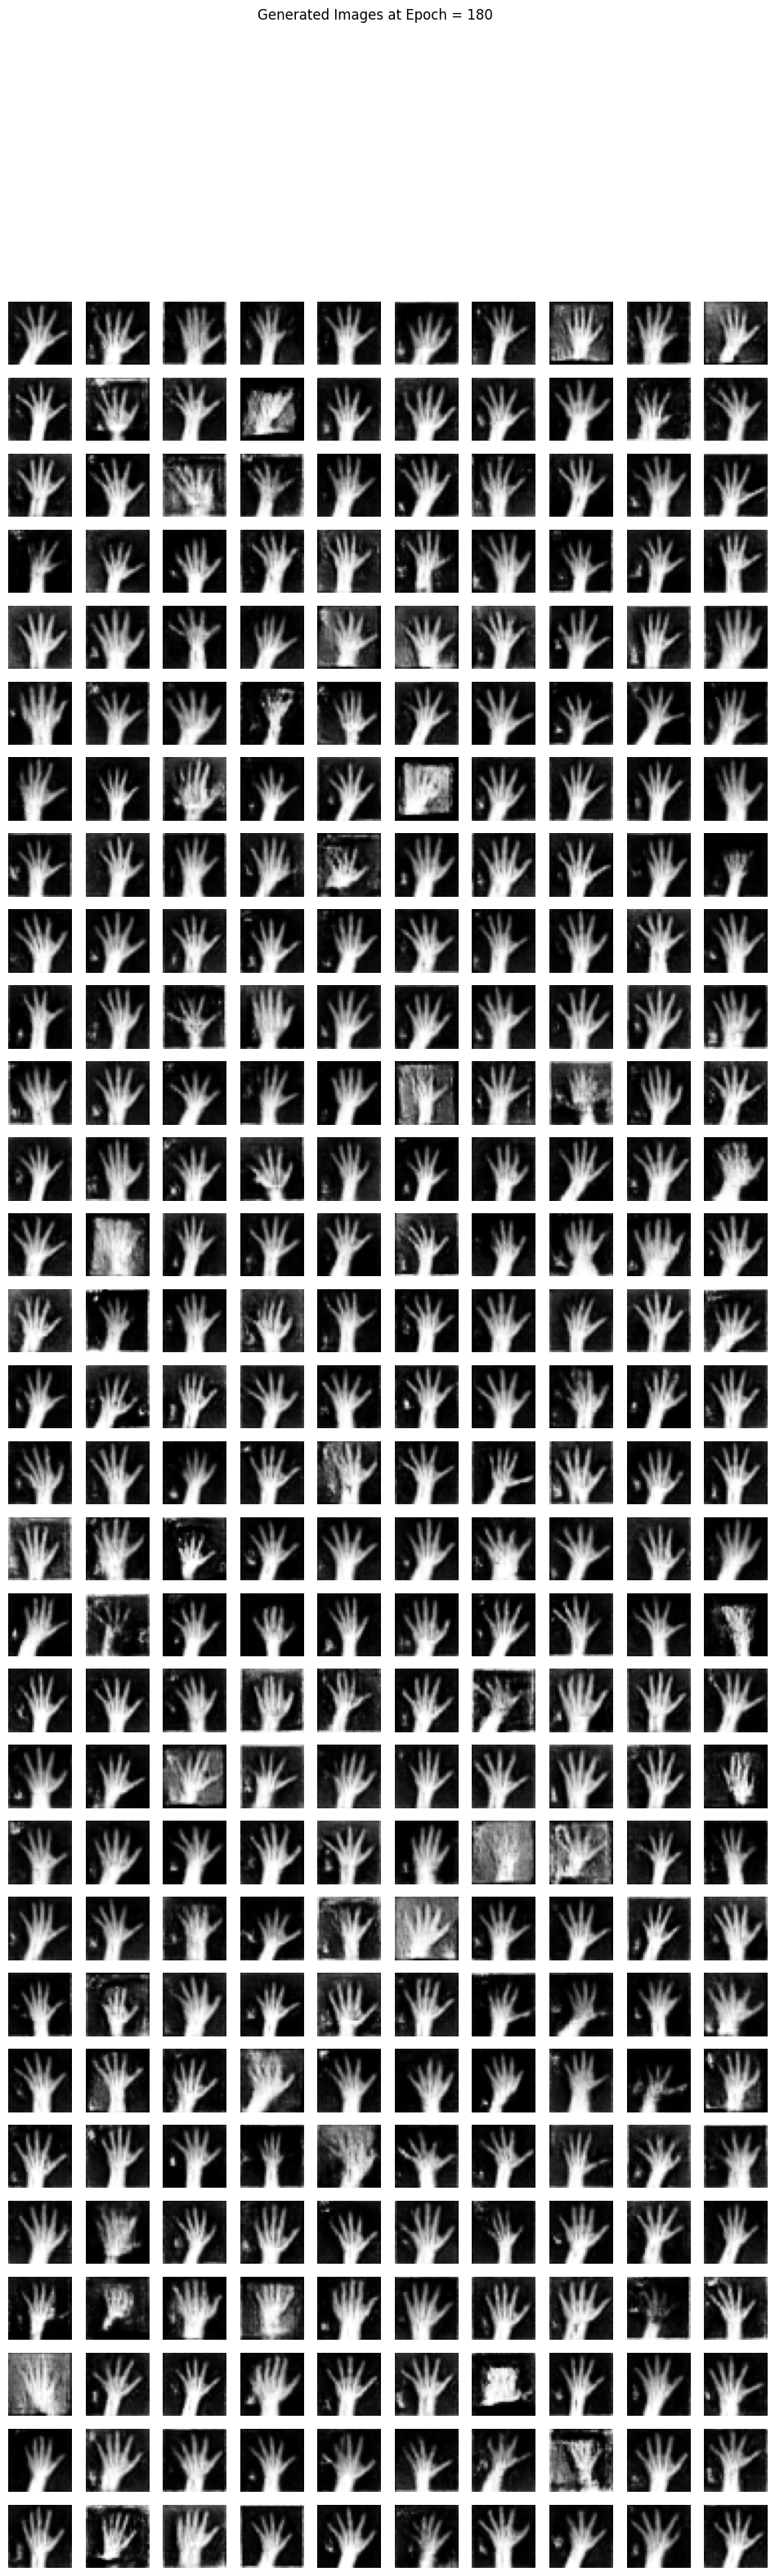

In [29]:
set_seed(0)

epoch = 180  # Load the model after 20 epochs
G8.load_state_dict(torch.load("./LectureModel8_{:03d}.pth".format(epoch)))
G8.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim, 1, 1).to(device)  # Generate a batch of 100 latent vectors
        generated = G8(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


We can now try the **Xavier** initialisation.
Conference Paper: **Understanding the difficulty of training deep feedforward neural networks** [Xavier Glorot, Yoshua Bengio Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics, PMLR 9:249-256, 2010.]

In [ ]:
def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator10(nn.Module):
    def __init__(self, latent_dim):
        super(Generator10, self).__init__()
        self.model = nn.Sequential(
            # First layer, projecting and reshaping the latent vector
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Upsample to 8x8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample to 16x16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # Upsample to 32x32
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=True),
            nn.Tanh()  # Tanh for normalizing the output to [-1, 1]
        )

    def forward(self, z):
        return self.model(z)



class Discriminator10(nn.Module):
    def __init__(self):
        super(Discriminator10, self).__init__()
        self.model = nn.Sequential(
            # Input is a 1x32x32 image
            nn.Conv2d(1, 32, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 16x16
            nn.Conv2d(32, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 8x8
            nn.Conv2d(64, 128, 4, 2, 1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer
            nn.Conv2d(128, 1, 4, 1, 0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

G10 = Generator10(50).to(device)
D10 = Discriminator10().to(device)


G10 = Generator10(50).to(device)
G10.apply(weights_init_xavier)
D10 = Discriminator10().to(device)
D10.apply(weights_init_xavier)

In [ ]:
criterion = nn.BCELoss()
z_dim = 50
bs = 100  ## batch_size

beta1 = 0.5
beta2 = 0.999

# optimiser
lr = 0.0001
G10_optimizer = torch.optim.Adam(G10.parameters(), lr = lr, betas=(beta1, beta2))
D10_optimizer = torch.optim.Adam(D10.parameters(), lr = lr, betas=(beta1, beta2))

In [ ]:
def D10_train(x):
    current_batch_size = x.size(0)  # Get the actual size of the batch

    D10.zero_grad()

    # Train with real images
    real_data = x.to(device)
    real_labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size
    output = D10(real_data).view(-1, 1)
    D10_real_loss = criterion(output, real_labels)

    # Train with fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G10(noise)
    fake_labels = torch.zeros(current_batch_size, 1).to(device)  # Adjust label size
    output = D10(fake_data.detach()).view(-1, 1)
    D10_fake_loss = criterion(output, fake_labels)

    # Combine losses and perform backpropagation
    D10_loss = D10_real_loss + D10_fake_loss
    D10_loss.backward()
    D10_optimizer.step()

    return D10_loss.item()

In [ ]:
def G10_train(current_batch_size):  # Add current_batch_size as an argument
    G10.zero_grad()

    # Generate fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G10(noise)
    labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size

    # Calculate the generator's loss
    output = D10(fake_data).view(-1, 1)
    G10_loss = criterion(output, labels)

    # Backpropagation
    G10_loss.backward()
    G10_optimizer.step()

    return G10_loss.item()

In [ ]:
set_seed(0)
n_epoch = 400
# Assuming livelossplot is installed and imported if you plan to use it
# from livelossplot import PlotLosses

groups = {'Loss': ['D10_Loss', 'G10_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D10_losses, G10_losses = [], []
    logs = {}

    for batch_idx, x in enumerate(dataloader):
        # Handling the case for the last batch which might be smaller
        current_batch_size = x.size(0)

        # Update the discriminator
        D10_loss = D10_train(x)
        D10_losses.append(D10_loss)

        # Update the generator
        G10_loss = G10_train(current_batch_size)  # Pass the current batch size to G_train
        G10_losses.append(G10_loss)

        # Update logs for livelossplot, if used
        logs['D10_Loss'] = D10_loss
        logs['G10_Loss'] = G10_loss

    liveloss.update(logs)
    liveloss.draw()

    # Save model checkpoints
    if epoch % 20 == 0:
        torch.save(G10.state_dict(), f"./LectureModel10_{epoch:03d}.pth")

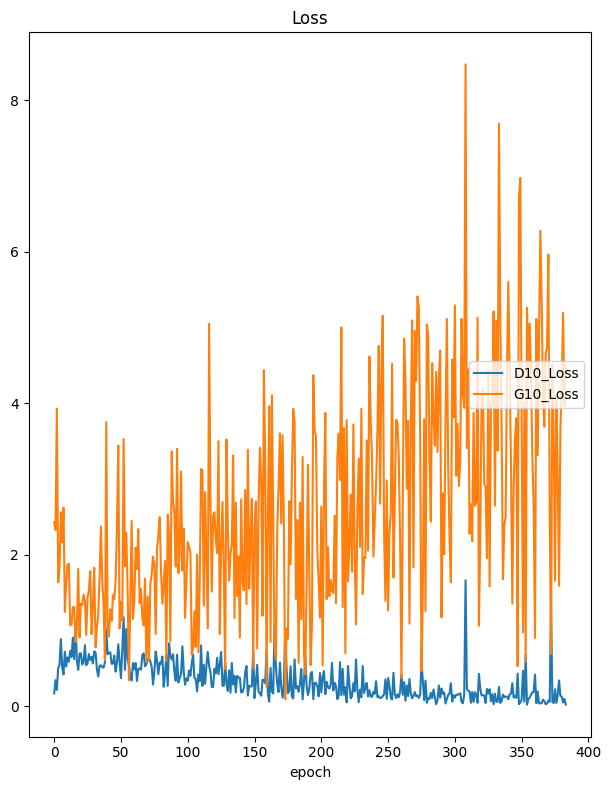

In [28]:
img_path = 'gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/ModelsImages/Xavier.png'
img = Image.open(img_path)
img

# Conclusion

We haven't managed to make the curves converge in the DCGAN's models. However, they still build better images than the GANs made up of linear layers.

So, we will use the normal DCGAN's model for our final results.

If we had more time, we could try more complex architectures and tune other hyperparameters like the learning rate, batch size, ...